In [1]:
import importlib
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt

# Data Generation

In [3]:
#this data is garbage but making just to have something to test the whole process with
n_rows = 5
n_features = 3
pred_dim = n_features 
# feature data just normally distributed
features = np.random.normal(size=(n_rows, n_features))
# say that each feature predicts a single stock according to linear relationship with small error term
slopes = np.random.uniform(size = n_features)
errs = np.random.normal(scale=0.01, size = (n_rows, n_features))
true_ys = np.multiply(features, slopes) + errs


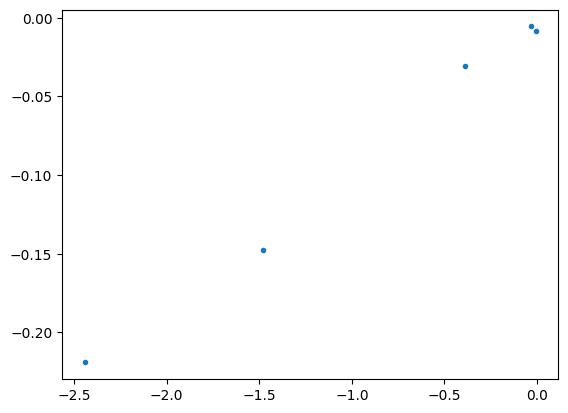

In [75]:
plt.plot(features[:,0], true_ys[:,0], '.')


# Generating Models to Ensemble

In [4]:
# first model predicts label mean everywhere

def h1(xs):
    # calculate label mean and duplicate it for each of xs
    return np.tile(np.average(ys, axis=0), (len(xs),1))
    

# second model predicts correct linear relationship for first stock and 0 everywhere else
def h2(xs):
    # build prediction 
    preds = np.zeros((len(xs), n_features))
    preds[:,0] = true_ys[:,0]
    return preds




Testing Policy Code

In [79]:
import policies
import importlib 
importlib.reload(policies)

simplex = policies.Simplex(pred_dim)
print(simplex.dim)
simplex.run(h2(features))


3


array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

Testing Debiasing Code

In [193]:
import debiasedModel
importlib.reload(debiasedModel)

X_train = features
Y_train = true_ys
init_model = h2
max_depth = 1
policy = simplex

model = debiasedModel.Debiased_model()
model.debias(X_train, Y_train, init_model, max_depth, policy)

0 t


<function debiasedModel.Debiased_model._update_model.<locals>.new_model(xs)>

array([[ 0.58923407, -0.62574831,  0.32330969],
       [-0.40244087,  0.86830014,  0.20660808],
       [ 1.07054528, -0.62574831,  0.32330969],
       [ 0.16185952, -0.62574831,  0.32330969],
       [ 0.80501255, -0.62574831,  0.32330969]])